In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from qs_stochastic_psystem import *

# Reglas de evolución del sistema

|          | **Descripción**                   | **Propensidad**                                                                                                                                                          | **Reacción**                                                                               | **Compartimento** |
|----------|-----------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|-------------------|
| $s_{0}$  | Creación $lasR$                   | $\kappa_{lasR}$                                                                                                                                                          | $lasR\to lasR+1$                                                                             | b                 |
| $s_{1}$  | Degradación $lasR$                | $lasR*\gamma_{lasR}$                                                                                                                                                     | $lasR\to lasR-1$                                                                             | b                 |
| $s_{2}$  | Creación $LasR$                   | $lasR*\kappa_{LasR}$                                                                                                                                                     | $LasR\to LasR+1$                                                                             | b                 |
| $s_{3}$  | Unión $AI_1 + LasR$               | $AI_1*LasR*\mu_{A1{\cdot}LasR}$                                                                                                                                          | $AI_1\to AI_1-1$ <br /> $R\to Las{\cdot}LasR-1$ <br /> $AI_1{\cdot}LasR\to AI_1{\cdot}LasR+1$    | b                 |
| $s_{4}$  | Rompimiento $AI_{1}{\cdot}LasR$   | $AI_{1}{\cdot}LasR*\sigma_{AI1{\cdot}LasR}$                                                                                                                              | $AI_1\to AI_1+1$ <br /> $LasR\to LasR+1$ <br /> $AI_1{\cdot}LasR\to AI_1{\cdot}LasR-1$           | b                 |
| $s_{5}$  | Degradación $LasR$                | $LasR*\gamma_{LasR}$                                                                                                                                                     | $LasR\to LasR-1$                                                                             | b                 |
| $s_{6}$  | Creación $rsaL$                   | $\alpha_{rsaL}+\beta_{rsaL}\frac{K_{1}^{h_{1}}}{(K_{1}^{h_{1}} + LasR{\cdot}AI_1^{h_{1}})}$                                                                              | $rsaL\to rsaL+1$                                                                             | b                 |
| $s_{7}$  | Degradación $rsaL$                | $rsaL*\gamma_{rsaL}$                                                                                                                                                     | $rsaL\to rsaL-1$                                                                             | b                 |
| $s_{8}$  | Creación $RsaL$                   | $rsaL*\kappa_{RsaL}$                                                                                                                                                     | $RsaL\to RsaL+1$                                                                             | b                 |
| $s_{9}$  | Degradación $RsaL$                | $RsaL*\gamma_{RsaL}$                                                                                                                                                     | $RsaL\to RsaL-1$                                                                             | b                 |
| $s_{10}$ | Creación $lasI$                   | $\alpha_{lasI}+\beta_{lasI}\frac{K_{2}^{h_{2}}}{(K_{2}^{h_{2}} + LasR{\cdot}AI_1^{h_{2}})}$ <br /> $+ \beta_{lasI}\frac{K_{3}^{h_{3}}}{(K_{3}^{h_{3}} + RsaL^{h_{3}})}$  | $lasI\to lasI+1$                                                                             | b                 |
| $s_{11}$ | Degradación $lasI$                | $lasI*\gamma_{lasI}$                                                                                                                                                     | $lasI\to lasI-1$                                                                             | b                 |
| $s_{12}$ | Creación $LasI$                   | $lasI*\kappa_{LasI}$                                                                                                                                                     | $LasI\to LasI+1$                                                                             | b                 |
| $s_{13}$ | Degradación $LasI$                | $LasI*\gamma_{LasI}$                                                                                                                                                     | $LasI\to LasI-1$                                                                             | b                 |
| $s_{14}$ | Creación $A1_1$                   | $LasI*\kappa_{AI_1}$                                                                                                                                                     | $A1_1\to A1_1+1$                                                                             | b                 |
| $s_{15}$ | Degradación $A1_1$                | $AI_1*\gamma_{AI_1}$                                                                                                                                                     | $AI_1\to AI_1-1$                                                                             | b                 |
| $s_{16}$ | Difusión $A_1$                    | $AI_1*d$                                                                                                                                                                 | $AI_1\to AI_1-1$ <br /> $AI_{1ext}\to AI_{1ext}+1$                                             | b                 |
| $s_{17}$ | Degradación $AI_{1}{\cdot}LasR$   | $AI_{1}{\cdot}LasR*\gamma_{AI1{\cdot}LasR}$                                                                                                                              | $AI_1{\cdot}LasR\to AI_1{\cdot}LasR-1$                                                       | b                 |
| $s_{18}$ | Difusión $AI_{1ext}$       | $AI_{1ext}*d$                                                                                                                                                                   | $AI_1\to AI_1+1$ <br /> $AI_{1ext}\to AI_{1ext}-1$                                             | e                 |
| $s_{19}$ | Degradación $AI_{1ext}$    | $AI_{1ext}*(\gamma_{A1}+d_{away)}$                                                                                                                                              | $AI_{1ext}\to AI_{1ext}-1$                                                                   | e                 |

In [2]:
multicompartmental_gillespie()

bacteria_grouped, environment = load_data()

Simulation completed! 
 Cells: 10 
 Simulation time: 10000 seconds


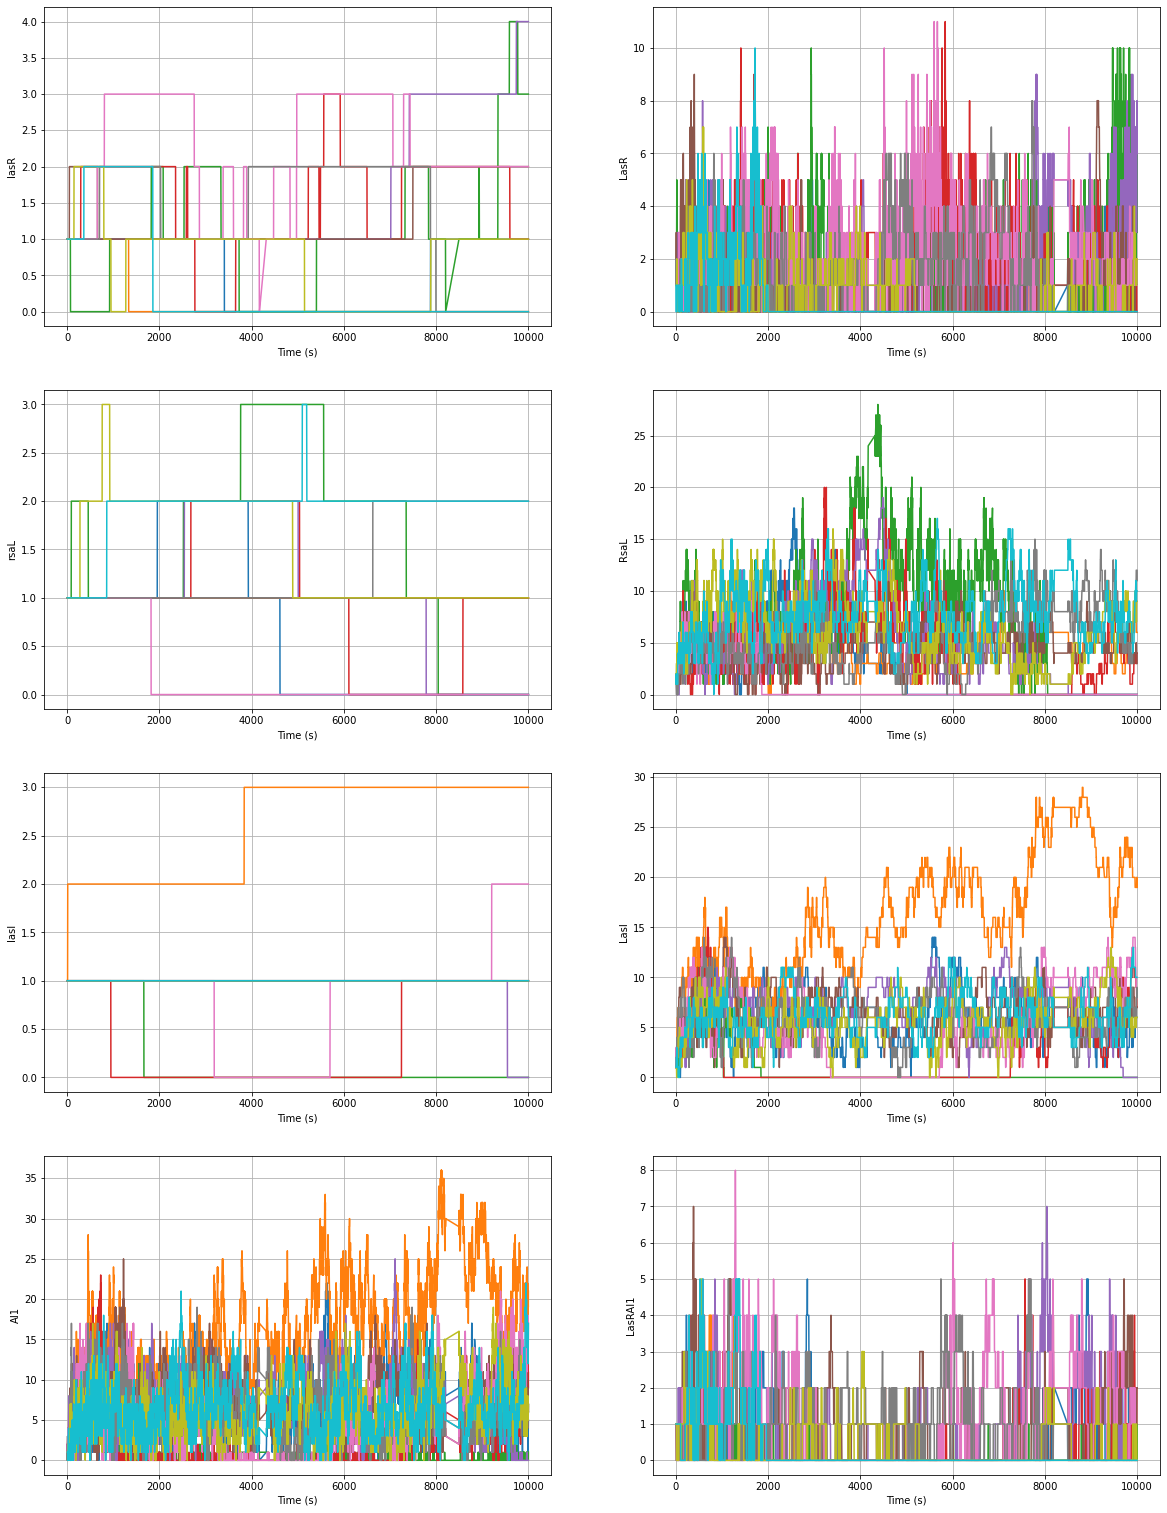

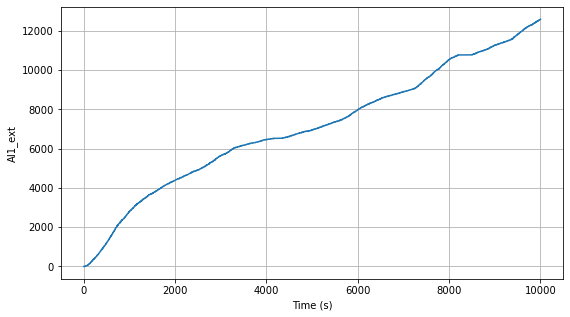

In [3]:
plot_mcg(bacteria_grouped, environment)
plt.show()